# Regression for galaxy borders detection #4.5 (ResNet18)
---
<!--
| Sesion | Fecha de realizacion | Author |
|:-------|:--------------------:|:-------------------|
|   3ª   |      09/12/2020      | Jorge Barrio Conde |
-->

**Author**: Jorge Barrio Conde

## Version

**Version**: 4.5. CNN: resnet18

**Loss function**: MAE Label Smoothing with angle normalization

**Metric**: MAE (Mean-Absolute Error)

**Neural Network**: ResNet18

**Epochs**: 50

**Learning rate**: 1e-01

**Tfms**: `[Normalize.from_stats(mean=0.0, std=1.0), GaussianNoise(), RotateTfm(), MovementTfm(min=-10, max=11)]`

## 0. Install fastai and fastbook

-U: Upgrade all specified packages to the newest available version

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.4MB/s 
     |████████████████████████████████| 1.2MB 43.6MB/s 
     |████████████████████████████████| 204kB 52.3MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
Mounted at /content/gdrive


## 1. Imports and paths

In [ ]:
import fastai
import fastbook
from fastai.vision.all import *
from fastbook import *

In [ ]:
print(f"fastai version: {fastai.__version__}")
print(f"fastbook version: {fastbook.__version__}")

fastai version: 2.3.1
fastbook version: 0.0.16


**Paths**

In [ ]:
# Specify project path
project_root_path = "/content/gdrive/MyDrive/galaxy_edge_detection/"

In [ ]:
dataset_dir_path = project_root_path + "dataset/"
png_folder_path = dataset_dir_path + "rgb_200x200_low/"
csv_path = project_root_path + "results/" + "4.5.-CNN-resnet18-50_epochs-lr_1e-01.csv"

## 2. Read dataset

### 2.1. Read CSV

**`gal_id`**: filename (`morphology_galaxyId_candelsField`)

**`q`**: axis ratio → `minor axis` = `major axis` $*$ `q`

**`pa`**: angle between the major axis and the 'y' axis → range $[-90, 90]$

**`r_edge`**: major axis

**`xcH`**: center of galaxy (x axis)

**`ycH`**: center of galaxy (y axis)

In [ ]:
df = pd.read_csv(dataset_dir_path+"benja_ppales_params_low_v4.csv")
df.head()

,gal_id,q,pa,r_edge,xcH,ycH
0,DISK_270_cosmos,0.2390,79.8405,31.859297,100.0,100.0
1,DISK_283_cosmos,0.2843,76.1063,17.744582,100.0,100.0
2,DISKSPH_886_cosmos,0.3449,-62.4947,35.659255,100.0,100.0
3,DISKSPH_944_cosmos,0.2000,14.0000,45.867763,100.0,100.0
4,DISK_1022_cosmos,0.6500,-70.0000,41.548721,100.0,100.0


In [ ]:
print(f"Dataset size: {len(df)}")

Dataset size: 1053


### 2.2. Process columns
Calculate minor axis and major axis

In [ ]:
df["majorAxis"] = df["r_edge"]
df["minorAxis"] = df["majorAxis"] * df["q"]
df.head()

,gal_id,q,pa,r_edge,xcH,ycH,majorAxis,minorAxis
0,DISK_270_cosmos,0.2390,79.8405,31.859297,100.0,100.0,31.859297,7.614372
1,DISK_283_cosmos,0.2843,76.1063,17.744582,100.0,100.0,17.744582,5.044785
2,DISKSPH_886_cosmos,0.3449,-62.4947,35.659255,100.0,100.0,35.659255,12.298877
3,DISKSPH_944_cosmos,0.2000,14.0000,45.867763,100.0,100.0,45.867763,9.173553
4,DISK_1022_cosmos,0.6500,-70.0000,41.548721,100.0,100.0,41.548721,27.006669


## 3. My functions

### 3.1. Getters

In [ ]:
def get_x(r):
    return png_folder_path + r['gal_id'] + '.png'

In [ ]:
def get_y(r):
    return (tensor([r['pa'], r['xcH'], r['ycH'], r['majorAxis'], r['minorAxis']]))

### 3.2. Tfms

In [ ]:
class GaussianNoise(Transform):
    order = 100 #after normalize
    
    def encodes(self, x:TensorImage):
        noise = torch.normal(
            mean=0.0, 
            std=0.005,
            size=x.shape,
            device='cuda'
        )
        return x + noise

In [ ]:
class RotateTfm(Transform):
    split_idx  =  0 # Only apply to the training set
    order = 101
    def encodes(self, x:Tensor):
        if isinstance(x, TensorImage):
            """
            TensorImages
            """
            # Generate random values between 0 and 3
            # 0: 0.0, 1: 90.0, 2: 180.0, 3: 270.0
            self.rotation = torch.randint(
                low=0, high=4, size=(x.shape[0],), 
                dtype=torch.int, device='cuda'
            )
            
            for img_idx in range(x.shape[0]):
                for ch_idx in range(x.shape[1]):
                    for r in range(self.rotation[img_idx]):
                        x[img_idx][ch_idx] = torch.rot90(
                            x[img_idx][ch_idx], 1, [0, 1]
                        )
        else:
            """
            Regression values
            """
            for img_idx in range(x.shape[0]):
                if self.rotation[img_idx]%2 != 0:
                    x[img_idx][0] = (
                        x[img_idx][0] + 90 
                        if x[img_idx][0] < 0 
                        else x[img_idx][0] - 90
                    )

        return x

In [ ]:
class MovementTfm(Transform):
    split_idx  =  0
    order = 102 #after normalize
    
    def __init__(self, min:int, max:int):
        super()

        self.min = min
        self.max = max

    def encodes(self, x:Tensor):
        if isinstance(x, TensorImage):
            """
            TensorImages
            """
            self.movements = torch.randint(
                low=self.min, high=self.max, 
                size=(2, x.shape[0]), 
                dtype=torch.int, device='cuda'
            )
            
            for img_idx in range(x.shape[0]):
                for ch_idx in range(x.shape[1]):
                    y_movement = self.movements[0][img_idx]
                    x_movement = self.movements[1][img_idx]
                    
                    x[img_idx][ch_idx] = torch.roll(
                        x[img_idx][ch_idx], 
                        shifts=(y_movement, x_movement),
                        dims=(0,1)
                    )

                    #Remove pixels that fall out of the tensor
                    if(x_movement >= 0):
                        x[img_idx][ch_idx][:,0:x_movement] = 0
                    else:
                        x[img_idx][ch_idx][:,x_movement:] = 0
                        
                    if(y_movement >= 0):
                        x[img_idx][ch_idx][0:y_movement] = 0
                    else:
                        x[img_idx][ch_idx][y_movement:] = 0
        else:
            """
            Regression values
            """
            for img_idx in range(x.shape[0]):
                x[img_idx][1] += self.movements[0][img_idx] #X
                x[img_idx][2] += self.movements[1][img_idx] #Y
                
        return x

### 3.3. Loss function

Label smoothing: 10% maximum

In [ ]:
def mae_label_smoothing(preds, targs):
    targs += (torch.rand(targs.size(1),device='cuda')-0.5)*0.1
    return (preds-targs).abs().mean()

In [ ]:
def mae_angle(preds, targs):
    if len(preds.shape) != 1:
        preds = torch.transpose(preds, 0, 1)
        targs = torch.transpose(targs, 0, 1)

    errors =  torch.zeros(preds.shape, dtype=torch.float)
    
    pa1_errors = (preds[0]-targs[0]).abs()
    pa2_errors = (preds[0]-(targs[0]+180)).abs()
    pa_errors = torch.min(pa1_errors, pa2_errors)
    
    pa3_errors = (preds[0]-(targs[0]-180)).abs()
    pa_errors = torch.min(pa_errors, pa3_errors)

    errors[0] = pa_errors

    for i in range(1, 5):
        errors[i] = tensor((preds[i]-targs[i]).abs())

    return errors.mean()

def mae_label_smoothing_angle(preds, targs):
    targs += (torch.rand(targs.size(1),device='cuda')-0.5)*0.1

    return mae_angle(preds, targs)

### 3.4. Show edge

#### 3.4.1. Imports

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#### 3.4.2. Simple show_edge

In [ ]:
def show_edge(x, y):
    if isinstance(x, TensorImage):
        x = x.data
        if x.shape[0]<5: x=x.permute(1,2,0)
        
    img = x
    fig, ax = plt.subplots()
    ax.imshow(img)

    ax.add_patch(
        Ellipse(
            (y[1], y[2]), 
            width=y[4]*2, 
            height=y[3]*2,
            angle=180-y[0],
            edgecolor='red',
            facecolor='none',
            linewidth=2
        )
    )

    values = f"""
PA = {y[0]:.3f}
xcH = {y[1]:.3f}
ycH = {y[2]:.3f}
Major axis = {y[3]:.3f}
Minor axis = {y[4]:.3f}
"""
    ax.set_xlabel(values) 

#### 3.4.3. Get items from dataloaders

In [ ]:
def get_valid_dataloader_items(dls):
    """
    Get all TensorImage and regression values from valid dataloader
    """
    xs = []
    ys = []

    for batch_index, batch_data in enumerate(dls.valid): 
        # batch_data = (List[TensorImage], List[Tensor])
        new_xs,new_ys,new_its = dls.show_batch(batch_data, max_n=batch_data[0].shape[0], show=False)
        for index, new_x in enumerate(new_xs):
            xs.append(TensorImage(new_x.cpu()))
            ys.append(new_ys[index].cpu())

    return xs, ys

In [ ]:
def get_valid_dataloader_items_with_preds(dls):
    """
    Get all TensorImage and regression values from valid dataloader and 
    its predictions
    """
    xs = []
    ys = []
    preds = []
    targs = []

    for batch_index, batch_data in enumerate(dls.valid): 
        # batch_data : (List[TensorImage], List[Tensor])
        new_xs,new_ys,new_its = dls.show_batch(batch_data, max_n=batch_data[0].shape[0], show=False)
        new_preds, new_targs = learn.get_preds(dl=[batch_data])

        for index, new_x in enumerate(new_xs):
            xs.append(TensorImage(new_x.cpu()))
            ys.append(new_ys[index].cpu())
            preds.append(new_preds[index])
            targs.append(new_targs[index])

    return xs, ys, preds, targs

In [ ]:
def get_train_dataloader_items(dls):
    """
    Get all TensorImage and regression values from train dataloader
    """
    xs = []
    ys = []

    for batch_index, batch_data in enumerate(dls.train): 
        # batch_data = (List[TensorImage], List[Tensor])
        new_xs,new_ys,new_its = dls.show_batch(batch_data, max_n=batch_data[0].shape[0], show=False)
        for index, new_x in enumerate(new_xs):
            xs.append(TensorImage(new_x.cpu()))
            ys.append(new_ys[index].cpu())

    return xs, ys

#### 3.4.4. Show edge results

In [ ]:
def show_edge_result(x, targs, preds, metric):
    if isinstance(x, TensorImage):
        x = x.data
        if x.shape[0]<5: x=x.permute(1,2,0)
        
    img = x

    fig = plt.figure(figsize=(8, 5))
    fig.suptitle(f"MAE = {metric:4f}", fontsize=16, y=0.95)

    # Targets
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(img)
    ax.set_title("Targets")

    ax.add_patch(
        Ellipse(
            (targs[1], targs[2]), 
            width=targs[4]*2, 
            height=targs[3]*2,
            angle=180-targs[0],
            edgecolor='red',
            facecolor='none',
            linewidth=2
        )
    )

    values = f"""
PA = {targs[0]:.3f}
xcH = {targs[1]:.3f}
ycH = {targs[2]:.3f}
Major axis = {targs[3]:.3f}
Minor axis = {targs[4]:.3f}
"""
    ax.set_xlabel(values)

    # Predictions
    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img)
    ax.set_title("Predictions")
    
    ax.add_patch(
        Ellipse(
            (preds[1], preds[2]), 
            width=preds[4]*2, 
            height=preds[3]*2,
            angle=180-preds[0],
            edgecolor='red',
            facecolor='none',
            linewidth=2
        )
    )   

    values = f"""
PA = {preds[0]:.3f} (\u03B5 = {targs[0]-preds[0]:.2f})
xcH = {preds[1]:.3f} (\u03B5 = {targs[1]-preds[1]:.2f})
ycH = {preds[2]:.3f} (\u03B5 = {targs[2]-preds[2]:.2f})
Major axis = {preds[3]:.3f} (\u03B5 = {targs[3]-preds[3]:.2f})
Minor axis = {preds[4]:.3f} (\u03B5 = {targs[4]-preds[4]:.2f})
"""
    ax.set_xlabel(values) 

In [ ]:
def get_metrics_dict(preds, targs):
    metrics = {}
    for i in range(len(preds)):
        metrics.update({ i : mae_angle(preds[i], targs[i]) })
    return metrics

In [ ]:
def show_edge_results(learn, dls, n_samples=5, random=True):
    xs, ys, preds, targs = get_valid_dataloader_items_with_preds(dls)

    metrics = get_metrics_dict(preds, targs)

    if random:
        indexes = torch.randint(0, len(preds), (n_samples,))
    else:
        indexes = [num for num in range(n_samples)]

    for i in range(n_samples):
        index = indexes[i]
        show_edge_result(xs[index], targs[index], preds[index], metrics[index]) 

In [ ]:
def show_edge_best_results(learn, dls, n_samples=5):
    xs, ys, preds, targs = get_valid_dataloader_items_with_preds(dls)

    metrics = get_metrics_dict(preds, targs)

    metrics = dict(sorted(metrics.items(), key=operator.itemgetter(1)))

    keys = list(metrics.keys())
    values=metrics.values()

    indexes = [keys[i] for i in range(n_samples)]
    
    for i in range(n_samples):
        index = indexes[i]
        show_edge_result(xs[index], targs[index], preds[index], metrics[index])

In [ ]:
def show_edge_worst_results(learn, dls, n_samples=5):
    xs, ys, preds, targs = get_valid_dataloader_items_with_preds(dls)

    metrics = get_metrics_dict(preds, targs)

    metrics = dict(sorted(metrics.items(), key=operator.itemgetter(1), reverse=True))

    keys = list(metrics.keys())

    indexes = [keys[i] for i in range(n_samples)]
    
    for i in range(n_samples):
        index = indexes[i]
        show_edge_result(xs[index], targs[index], preds[index], metrics[index])

### 3.5. Show results stats

In [ ]:
def show_results_stats(learn, dls):
    preds,targs = learn.get_preds()
    error = (preds-targs).abs()

    if error.mean() != mae(preds,targs):
        print("ESTOS ESTA MAL")

    print(f"MAE = {error.mean():.4f}")
    print("\nMean error for each value:")
    print(f"- PA = {error[0].mean():.4f}")
    print(f"- xcH = {error[1].mean():.4f}")
    print(f"- ycH = {error[2].mean():.4f}")
    print(f"- majorAxis = {error[3].mean():.4f}")
    print(f"- minorAxis = {error[4].mean():.4f}")

## 4. DataBlock

In [ ]:
tfms = [
    Normalize.from_stats(mean=0.0, std=1.0), 
    GaussianNoise(), 
    RotateTfm(),
    MovementTfm(min=-10, max=11)
]

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_x=get_x,
    get_y=get_y,
    batch_tfms=tfms
)

### 4.1. DataBlock information

In [ ]:
dblock.item_tfms

(#1) [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ]

In [ ]:
dblock.batch_tfms

(#5) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Normalize -- {'mean': tensor([[[[0.]]]], device='cuda:0'), 'std': tensor([[[[1.]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
decodes: (TensorImage,object) -> decodes
,GaussianNoise:
encodes: (TensorImage,object) -> encodes
decodes: ,RotateTfm:
encodes: (Tensor,object) -> encodes
decodes: ,MovementTfm:
encodes: (Tensor,object) -> encodes
decodes: ]

In [ ]:
dblock.summary(df)

Setting-up type transforms pipelines
0        DISK_270_cosmos  0.2390  79.8405  31.859297  100.0  100.0  31.859297   
1        DISK_283_cosmos  0.2843  76.1063  17.744582  100.0  100.0  17.744582   
2     DISKSPH_886_cosmos  0.3449 -62.4947  35.659255  100.0  100.0  35.659255   
3     DISKSPH_944_cosmos  0.2000  14.0000  45.867763  100.0  100.0  45.867763   
4       DISK_1022_cosmos  0.6500 -70.0000  41.548721  100.0  100.0  41.548721   
...                  ...     ...      ...        ...    ...    ...        ...   
1048      DISK_25056_uds  0.4662  59.4264  16.619979  100.0  100.0  16.619979   
1049   DISKSPH_25162_uds  0.4621  41.4502  28.001938  100.0  100.0  28.001938   
1050      DISK_25681_uds  0.3775 -57.5325  24.391211  100.0  100.0  24.391211   
1051   DISKSPH_25951_uds  0.4872 -46.4380  26.001467  100.0  100.0  26.001467   
1052   DISKSPH_26782_uds  0.4600  40.0000  32.588515  100.0  100.0  32.588515   

      minorAxis  
0      7.614372  
1      5.044785  
2     12.298877  

## 5. DataLoaders

In [ ]:
dls = dblock.dataloaders(df)

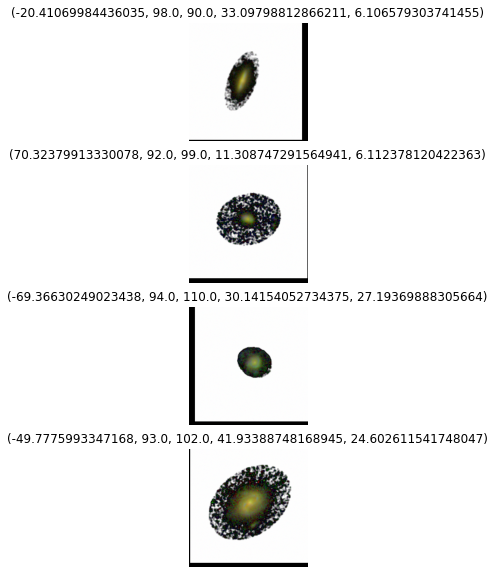

In [ ]:
dls.show_batch(nrows=4, ncols=1, figsize = (10, 10))

In [ ]:
dls.show

<bound method Datasets.show of (#843) [(PILImage mode=RGB size=200x200, tensor([-87.7194, 100.0000, 100.0000,  21.7299,  13.9354])),(PILImage mode=RGB size=200x200, tensor([-25.0000, 100.0000, 100.0000,  26.5325,  15.1235])),(PILImage mode=RGB size=200x200, tensor([-67.0359, 100.0000, 100.0000,  31.8361,  13.0528])),(PILImage mode=RGB size=200x200, tensor([-86.4701, 100.0000, 100.0000,  37.2940,  24.3940])),(PILImage mode=RGB size=200x200, tensor([-10.0705, 100.0000, 100.0000,  23.8540,  13.5944])),(PILImage mode=RGB size=200x200, tensor([ 82.2310, 100.0000, 100.0000,  32.5890,   7.0783])),(PILImage mode=RGB size=200x200, tensor([ -8.0000, 100.0000, 100.0000,  39.4076,   9.0637])),(PILImage mode=RGB size=200x200, tensor([ 73.6404, 100.0000, 100.0000,  53.7579,  14.8210])),(PILImage mode=RGB size=200x200, tensor([-26.4115, 100.0000, 100.0000,  39.5979,  34.7709])),(PILImage mode=RGB size=200x200, tensor([ 53.9306, 100.0000, 100.0000,  48.5267,  30.2564]))...]>

In [ ]:
dls.train.show

<bound method Datasets.show of (#843) [(PILImage mode=RGB size=200x200, tensor([-87.7194, 100.0000, 100.0000,  21.7299,  13.9354])),(PILImage mode=RGB size=200x200, tensor([-25.0000, 100.0000, 100.0000,  26.5325,  15.1235])),(PILImage mode=RGB size=200x200, tensor([-67.0359, 100.0000, 100.0000,  31.8361,  13.0528])),(PILImage mode=RGB size=200x200, tensor([-86.4701, 100.0000, 100.0000,  37.2940,  24.3940])),(PILImage mode=RGB size=200x200, tensor([-10.0705, 100.0000, 100.0000,  23.8540,  13.5944])),(PILImage mode=RGB size=200x200, tensor([ 82.2310, 100.0000, 100.0000,  32.5890,   7.0783])),(PILImage mode=RGB size=200x200, tensor([ -8.0000, 100.0000, 100.0000,  39.4076,   9.0637])),(PILImage mode=RGB size=200x200, tensor([ 73.6404, 100.0000, 100.0000,  53.7579,  14.8210])),(PILImage mode=RGB size=200x200, tensor([-26.4115, 100.0000, 100.0000,  39.5979,  34.7709])),(PILImage mode=RGB size=200x200, tensor([ 53.9306, 100.0000, 100.0000,  48.5267,  30.2564]))...]>

In [ ]:
dls.valid.show

<bound method Datasets.show of (#210) [(PILImage mode=RGB size=200x200, tensor([ 20.6562, 100.0000, 100.0000,  39.4185,  14.6164])),(PILImage mode=RGB size=200x200, tensor([-56.0357, 100.0000, 100.0000,  21.1577,   8.4737])),(PILImage mode=RGB size=200x200, tensor([ 13.4464, 100.0000, 100.0000,  24.1739,  13.4842])),(PILImage mode=RGB size=200x200, tensor([-65.4331, 100.0000, 100.0000,  33.7402,  15.3687])),(PILImage mode=RGB size=200x200, tensor([-25.3104, 100.0000, 100.0000,  35.5468,  13.7424])),(PILImage mode=RGB size=200x200, tensor([  8.0471, 100.0000, 100.0000,  16.1577,   7.5941])),(PILImage mode=RGB size=200x200, tensor([-10.0000, 100.0000, 100.0000, 104.6950,  94.2255])),(PILImage mode=RGB size=200x200, tensor([ 76.4813, 100.0000, 100.0000,  23.5149,  17.5610])),(PILImage mode=RGB size=200x200, tensor([-60.0000, 100.0000, 100.0000,  78.9057,  47.3434])),(PILImage mode=RGB size=200x200, tensor([-78.9120, 100.0000, 100.0000,  83.6974,  33.5878]))...]>

## 6. Learner

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

In [ ]:
model_meta[resnet18]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

### 6.1. Create Learner

In [ ]:
learn = cnn_learner(
    dls, resnet18, 
    metrics = mae_angle,
    loss_func=mae_label_smoothing_angle,
    cbs = [
        ShowGraphCallback(),
        CSVLogger(fname=csv_path, append=true)
    ]
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### 6.2. Results before training

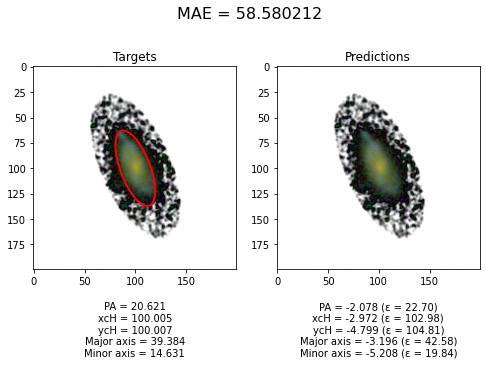

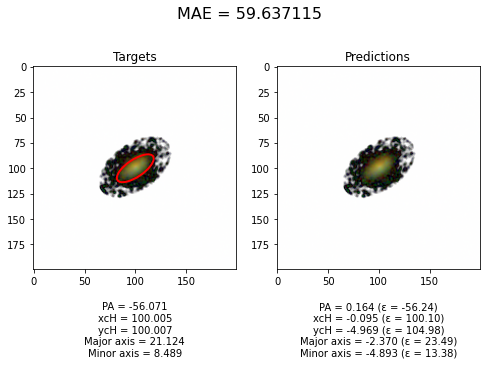

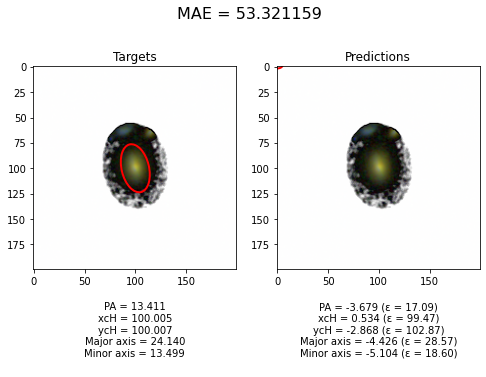

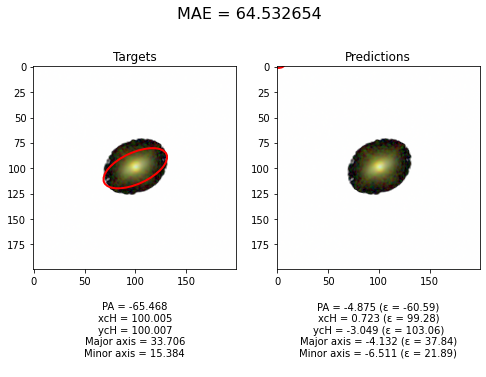

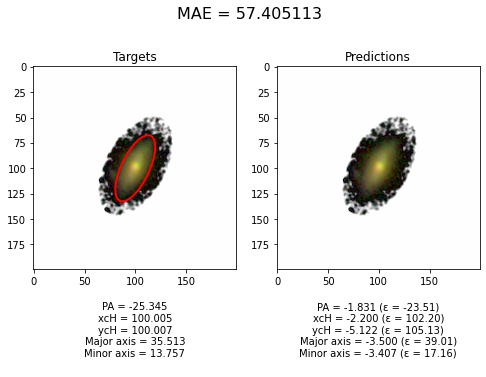

In [ ]:
show_edge_results(learn, dls, n_samples=5, random=False)

### 6.3. Fit

epoch,train_loss,valid_loss,mae_angle,time
0,52.451626,40.581013,40.581013,01:52


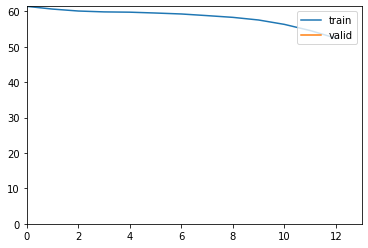

epoch,train_loss,valid_loss,mae_angle,time
0,14.546714,25.861517,25.861517,00:06
1,12.611012,10.981605,10.981605,00:06
2,11.415436,9.642670,9.642670,00:06
3,10.847363,8.862019,8.862019,00:05
4,10.585299,9.764379,9.764379,00:06
5,10.257185,11.170442,11.170442,00:05
6,9.887062,8.710763,8.710763,00:06
7,9.600913,11.674061,11.674061,00:06
8,9.615700,10.039398,10.039398,00:06
9,9.629380,12.868075,12.868075,00:06


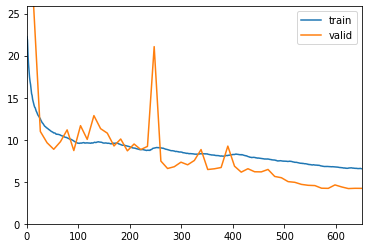

In [ ]:
learn.fine_tune(50, 1e-01)

### 6.4. Results after training

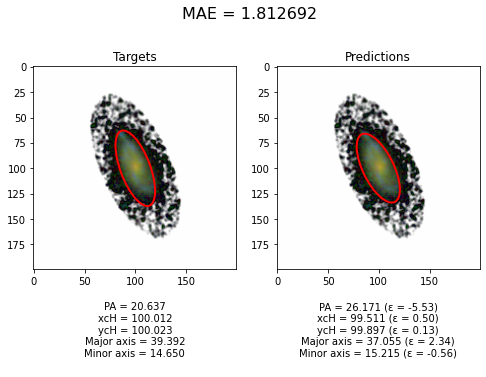

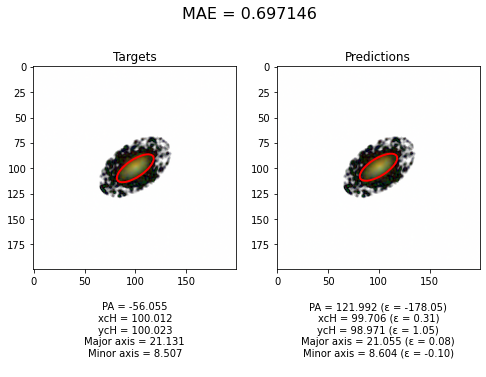

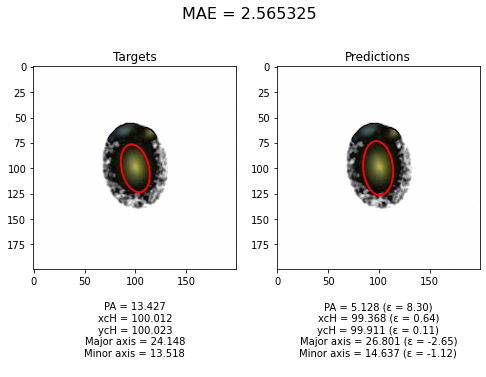

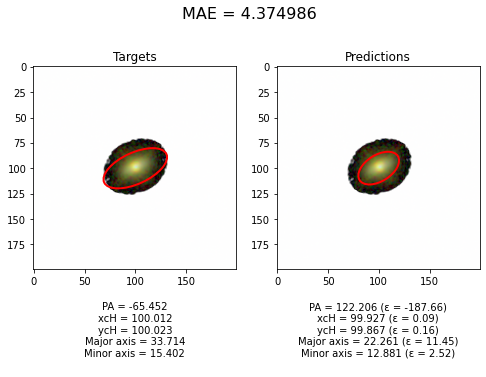

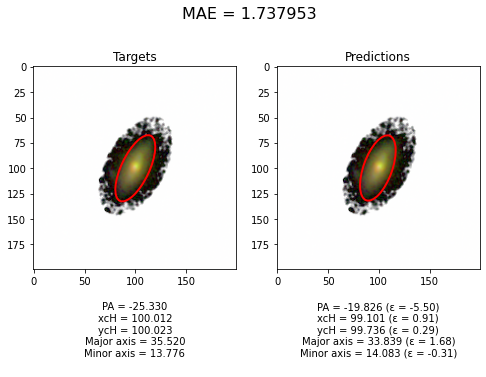

In [ ]:
show_edge_results(learn, dls, n_samples=5, random=False)

### 6.5. Best results

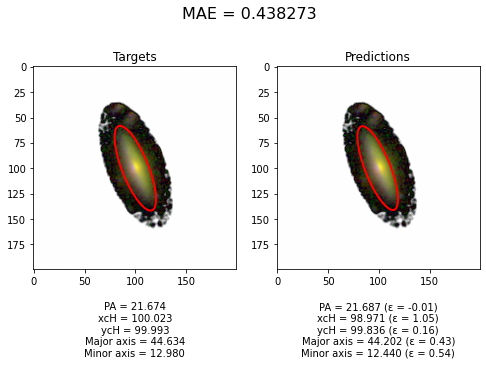

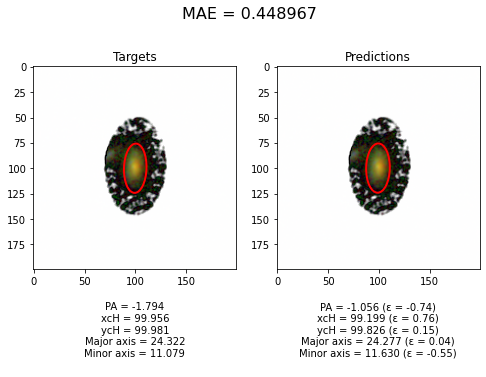

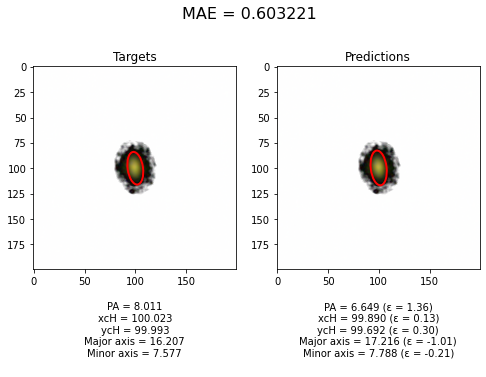

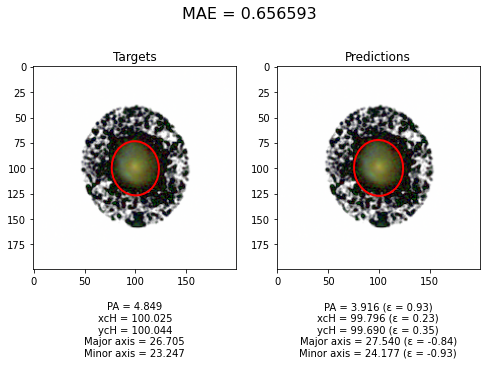

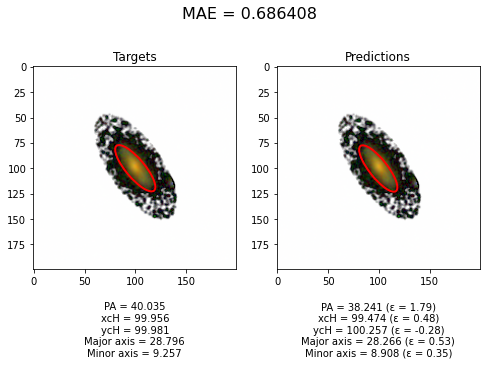

In [ ]:
show_edge_best_results(learn, dls, n_samples=5)

### 6.6. Worst results

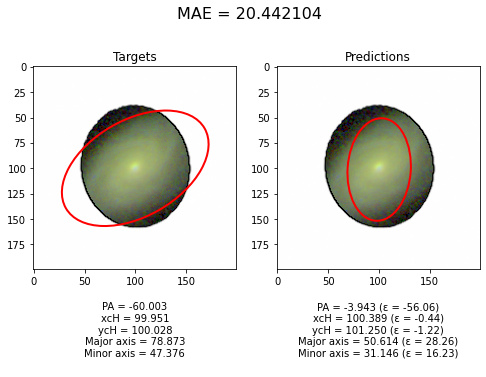

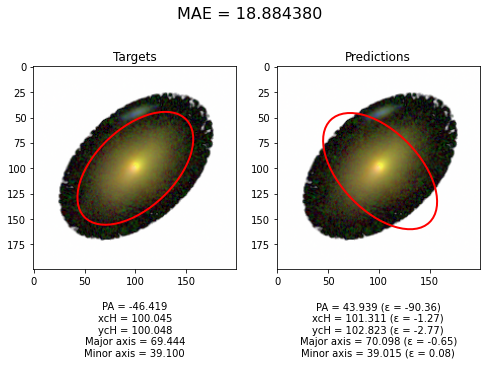

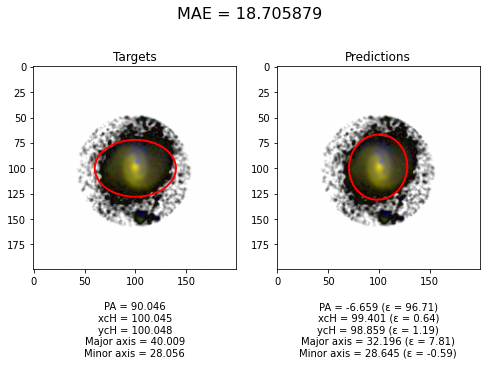

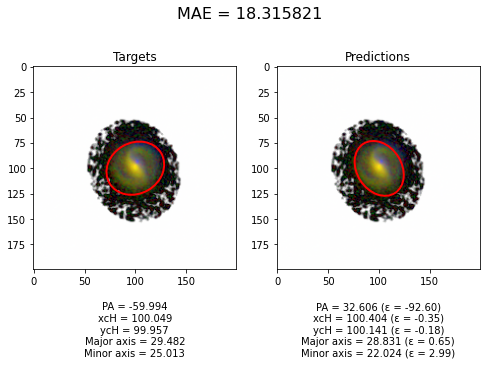

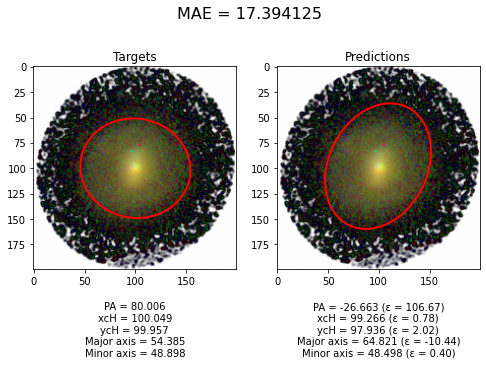

In [ ]:
show_edge_worst_results(learn, dls, n_samples=5)

### 6.7. Results stats

In [ ]:
show_results_stats(learn,dls)

MAE = 11.6152

Mean error for each value:
- PA = 1.7957
- xcH = 35.8932
- ycH = 2.5434
- majorAxis = 40.3525
- minorAxis = 1.7290


## 7. Tests

### 7.1. Show edge

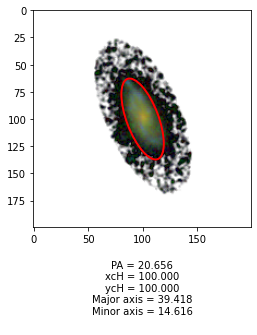

In [ ]:
show_edge(dls.valid_ds[0][0],dls.valid_ds[0][1])

### 7.2. No MovementTfm on valid dataloader 

In [ ]:
valid_xs, valid_ys = get_valid_dataloader_items(dls)

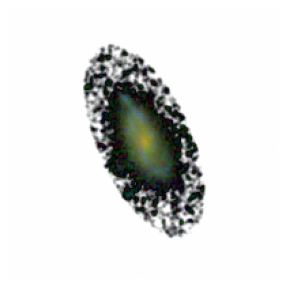

In [ ]:
valid_xs[0].show()

In [ ]:
for index in range(len(valid_ys)):
    if (
        valid_ys[index][1] != dls.valid_ds[index][1][1] or 
        valid_ys[index][2] != dls.valid_ds[index][1][2]
    ):
        print(f"Error: {y}")

### 7.3. No RotateTfm on valid dataloader 

In [ ]:
for index in range(len(valid_ys)):
    if valid_ys[index][0] != dls.valid_ds[index][1][0]:
        print(f"Error: {y}")

###7.4. Transform on train dataloader

In [ ]:
train_xs, train_ys = get_train_dataloader_items(dls)

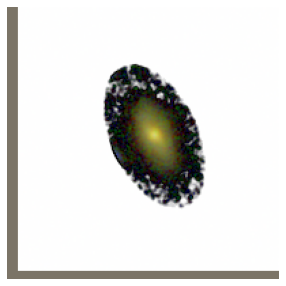

In [ ]:
train_xs[0].show()

In [ ]:
train_ys[0]

tensor([ 20.0000,  94.0000, 108.0000,  33.6777,  16.1653])

In [ ]:
xs, ys = dls.one_batch()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


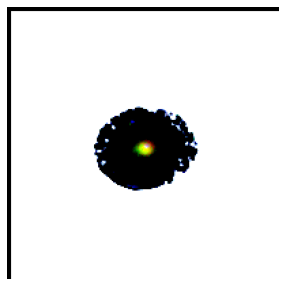

In [ ]:
xs[0].show()

In [ ]:
ys[0]

tensor([-87.7194, 103.0000, 103.0000,  21.7299,  13.9354], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


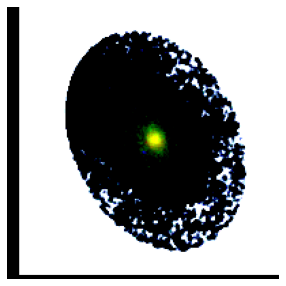

In [ ]:
xs[1].show()

In [ ]:
ys[1]

tensor([ 22.5000,  97.0000, 109.0000,  44.5757,  31.2030], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


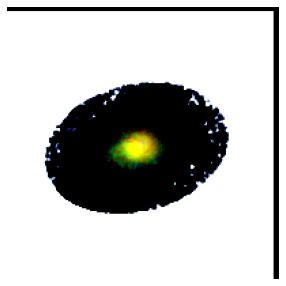

In [ ]:
xs[2].show()

In [ ]:
dls.train_ds[1][1]

tensor([-25.0000, 100.0000, 100.0000,  26.5325,  15.1235])

###7.4. Test new metric and loss function (angle)

In [ ]:
x = valid_xs[0]
y = valid_ys[0]

MAE: TensorBase(0.)
MAE with angle correction: tensor(0.)


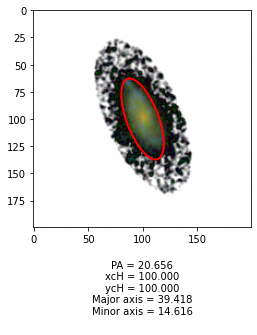

In [ ]:
show_edge(x,y)
print("MAE: "+str(mae(y,y)))
print("MAE with angle correction: "+str(mae_angle(y,y)))

MAE: TensorBase(36.)
MAE Angulo: tensor(0.)


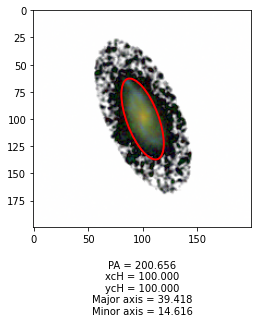

In [ ]:
y2 = y.clone()
y2[0] = y2[0]+180
show_edge(x,y2)
print("MAE: "+str(torch.round(mae(y,y2))))
print("MAE Angulo: "+str(torch.round(mae_angle(y,y2))))

MAE: TensorBase(36.)
MAE Angulo: tensor(0.)


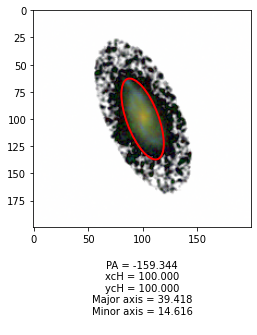

In [ ]:
y2 = y.clone()
y2[0] = y2[0]-180
show_edge(x,y2)
print("MAE: "+str(torch.round(mae(y,y2))))
print("MAE Angulo: "+str(torch.round(mae_angle(y,y2))))